Bernoulli trials are one of the simplest experimential setups: there are a number of iterations of some activity, where each iteration (or trial) may turn out to be a "success" or a "failure". From the data on T trials, we want to estimate the probability of "success".

Since it is such a simple case, it is a nice setup to use to describe some of Python's capabilities for estimating statistical models. Here I show estimation from the Bayesian perspective, via Metropolis-Hastings MCMC methods.

In [another post](./bernoulli_trials_classical.html) I show estimation of the problem in Python using the classical / frequentist approach.

<!-- TEASER_END -->

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sympy as sp
import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma

from sympy.interactive import printing
printing.init_printing()

### Setup

Let $y$ be a Bernoulli trial:

$y \sim \text{Bernoulli}(\theta) = \text{Binomial}(1, \theta)$

The probability density function, or marginal likelihood function, is:

$$p(y|\theta) = \theta^{y} (1-\theta)^{1-y} = \begin{cases}
\theta & y = 1 \\
1 - \theta & y = 0
\end{cases}$$

In [7]:
# Simulate data
np.random.seed(123)

nobs = 100
theta = 0.3
Y = np.random.binomial(1, theta, nobs)

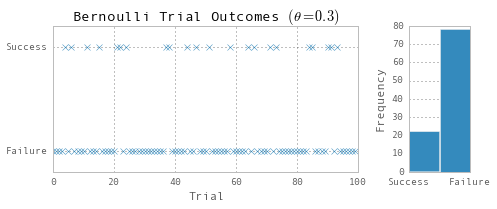

In [8]:
# Plot the data
fig = plt.figure(figsize=(7,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(range(nobs), Y, 'x')
ax2.hist(-Y, bins=2)

ax1.yaxis.set(ticks=(0,1), ticklabels=('Failure', 'Success'))
ax2.xaxis.set(ticks=(-1,0), ticklabels=('Success', 'Failure'));

ax1.set(title=r'Bernoulli Trial Outcomes $(\theta=0.3)$', xlabel='Trial', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')

fig.tight_layout()

### Bayesian Estimation

Using Bayes' rule:

$$p(\theta|Y) = \frac{p(Y|\theta) p(\theta)}{p(Y)}$$

To perform Bayesian estimation, we need to construct the __posterior__ $p(\theta|Y)$ given:

- the (joint) __likelihood__ $P(Y|\theta)$
- the __prior__ $p(\theta)$
- the __marginal probability density function__ $P(Y)$

to perform the estimation, we need to specify the functional forms of the likelihood and the prior. The marginal pdf of $Y$ is a constant with respect to $\theta$, so it does not need to specified for our purposes.

### Likelihood function

Consider a sample of $T$ draws from the random variable $y$. The joint likelihood of observing any specific sample $Y = (y_1, ..., y_T)'$ is given by:

$$
\begin{align}
p(Y|\theta) & = \prod_{i=1}^T \theta^{y_i} (1-\theta)^{1-y_i} \\
& = \theta^{s} (1 - \theta)^{T-s}
\end{align}
$$

where $s = \sum_i y_i$ is the number of observed "successes", and $T-s$ is the number of observed "failures".

In [9]:
t, T, s = sp.symbols('theta, T, s')

# Create the function symbolically
likelihood = (t**s)*(1-t)**(T-s)

# Convert it to a Numpy-callable function
_likelihood = sp.lambdify((t,T,s), likelihood, modules='numpy')

### Prior

Since $\theta$ is a probability value, our prior must respect $\theta \in (0,1)$. We will use the (conjugate) Beta prior:

$\theta \sim \text{Beta}(\alpha_1, \alpha_2)$

so that $(\alpha_1, \alpha_2)$ are the model's hyperparameters. Then the prior is specified as:

$$
p(\theta;\alpha_1,\alpha_2) = \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1}
$$

where $B(\alpha_1, \alpha_2)$ is the Beta function. Note that to have a fully specified prior, we need to also specify the hyperparameters.

Prior mean: 0


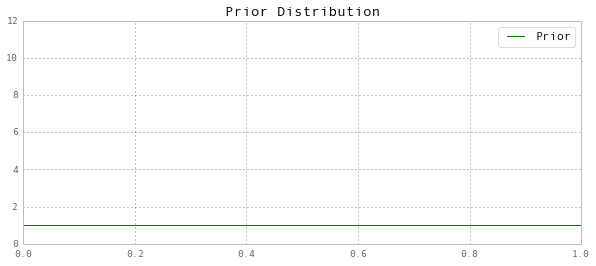

In [10]:
# For alpha_1 = alpha_2 = 1, the Beta distribution
# degenerates to a uniform distribution
a1 = 1
a2 = 1

# Prior Mean
prior_mean = a1 / (a1 + a2)
print 'Prior mean:', prior_mean

# Plot the prior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');

# Cleanup
ax.set(title='Prior Distribution', ylim=(0,12))
ax.legend(['Prior']);

### Posterior

#### Analytically

Given the prior and the likelihood function, we can try to find the kernel of the posterior analytically. In this case, it will be possible:

$$
\begin{align}
p(\theta|Y;\alpha_1,\alpha_2) & = \frac{P(Y|\theta) P(\theta)}{P(Y)} \\
& \propto P(Y|\theta) P(\theta) \\
& = \theta^s (1-\theta)^{T-s} \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1} \\
& \propto \theta^{s+\alpha_1-1} (1 - \theta)^{T-s+\alpha_2 - 1} \\
\end{align}
$$

The last line is identifiable as the kernel of a beta distribution with parameters $(\hat \alpha_1, \hat \alpha_2) = (s+\alpha_1, T-s+\alpha_2)$

Thus the posterior is given by

$$
P(\theta|Y;\alpha_1,\alpha_2) = \frac{1}{B(\hat \alpha_1, \hat \alpha_2)} \theta^{\hat \alpha_1 - 1} (1-\theta)^{\hat \alpha_2 -1}
$$

Posterior Mean (Analytic): 0


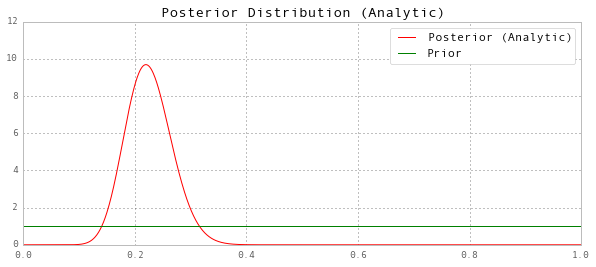

In [11]:
# Find the hyperparameters of the posterior
a1_hat = a1 + Y.sum()
a2_hat = a2 + nobs - Y.sum()

# Posterior Mean
post_mean = a1_hat / (a1_hat + a2_hat)
print 'Posterior Mean (Analytic):', post_mean

# Plot the analytic posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');

# Plot the prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');

# Cleanup
ax.set(title='Posterior Distribution (Analytic)', ylim=(0,12))
ax.legend(['Posterior (Analytic)', 'Prior']);

#### Metropolis-Hastings: Pure Python

Although since in this case the posterior can be found analytically for the conjugate Beta prior, we can also arrive at it as the stationary distribution of a Markov chain with Metropolis-Hastings transition kernel.

To do this, we need a proposal distribution $q(\theta|\theta^{[g]})$, and here we will use a random walk proposal: $\theta^* = \theta^{[g]} + \eta_t$ where $\eta_t \sim \text{Normal}(0,\sigma^2)$ where $\sigma^2$ will be set to get a desired acceptance ratio.

In [12]:
#%%timeit
print 'Timing: 1 loops, best of 3: 356 ms per loop'

# Metropolis-Hastings parameters
G1 = 1000 # burn-in period
G = 10000 # draws from the (converged) posterior

# Model parameters
sigma = 0.1
thetas = [0.5]             # initial value for theta
etas = np.random.normal(0, sigma, G1+G) # random walk errors
unif = np.random.uniform(size=G1+G)     # comparators for accept_probs

# Callable functions for likelihood and prior
prior_const = gamma(a1) * gamma(a2) / gamma(a1 + a2)
mh_ll = lambda theta: _likelihood(theta, nobs, Y.sum())
def mh_prior(theta):
    prior = 0
    if theta >= 0 and theta <= 1:
        prior = prior_const*(theta**(a1-1))*((1-theta)**(a2-1))
    return prior
mh_accept = lambda theta: mh_ll(theta) * mh_prior(theta)

theta_prob = mh_accept(thetas[-1])

# Metropolis-Hastings iterations
for i in range(G1+G):
    # Draw theta
    
    # Generate the proposal
    theta = thetas[-1]
    theta_star = theta + etas[i]
    theta_star_prob = mh_accept(theta_star)
    # Calculate the acceptance probability
    accept_prob = theta_star_prob / theta_prob
    
    # Append the new draw
    if accept_prob > unif[i]:
        theta = theta_star
        theta_prob = theta_star_prob
    thetas.append(theta)

Timing: 1 loops, best of 3: 356 ms per loop


We can describe the posterior using the draws after the chain has converged (i.e. following the burn-in period):

Posterior Mean (MH): 0.22532888147


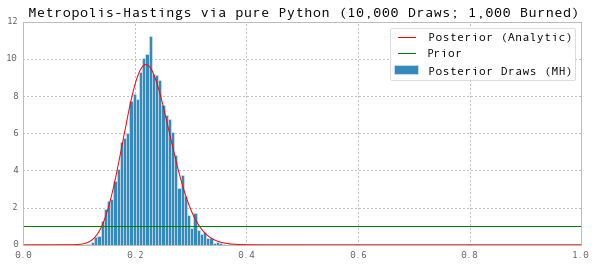

In [13]:
# Posterior Mean
print 'Posterior Mean (MH):', np.mean(thetas[G1:])

# Plot the posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
# Plot MH draws
ax.hist(thetas[G1:], bins=50, normed=True);
# Plot analytic posterior
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');
# Plot prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g')

# Cleanup
ax.set(title='Metropolis-Hastings via pure Python (10,000 Draws; 1,000 Burned)', ylim=(0,12))
ax.legend(['Posterior (Analytic)', 'Prior', 'Posterior Draws (MH)']);

#### Metropolis-Hastings: Cython

The runtime of 356ms is not bad, by we may be able to improve matters by writing it in Cython, a pseudo-language which is then compiled into a C extension that we can call from our Python code. In the right circumstances, this can speed up code dramatically.

Although I am not an expert in MATLAB, a pretty much direct port of this code to MATLAB (almost identical to the Cython code below) runs in about 400ms, so pure Python and MATLAB appear to be reasonably similar.

In [14]:
%load_ext cythonmagic

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [15]:
%%cython

import numpy as np
from scipy.special import gamma
cimport numpy as np
cimport cython

from libc.math cimport pow

cdef double likelihood(double theta, int T, int s):
    return pow(theta, s)*pow(1-theta, T-s)

cdef double prior(double theta, double a1, double a2, double prior_const):
    if theta < 0 or theta > 1:
        return 0
    return prior_const*pow(theta, a1-1)*pow(1-theta, a2-1)

cdef np.ndarray[np.float64_t, ndim=1] draw_posterior(np.ndarray[np.float64_t, ndim=1] theta, double eta, double unif, int T, int s, double a1, double a2, double prior_const):
    cdef double theta_star, theta_star_prob, accept_prob
    
    theta_star = theta[0] + eta
    theta_star_prob = likelihood(theta_star, T, s) * prior(theta_star, a1, a2, prior_const)
    
    accept_prob = theta_star_prob / theta[1]
    
    if accept_prob > unif:
        theta[0] = theta_star
        theta[1] = theta_star_prob
        
    return theta

def mh(double theta_init, int T, int s, double sigma, double a1, double a2, int G1, int G):
    
    cdef np.ndarray[np.float64_t, ndim = 1] theta, thetas, etas, unif
    cdef double prior_const, theta_prob
    cdef int t
    
    prior_const = gamma(a1) * gamma(a2) / gamma(a1 + a2)
    theta_prob = likelihood(theta_init, T, s) * prior(theta_init, a1, a2, prior_const)
    
    theta = np.array([theta_init, theta_prob])
    
    thetas = np.zeros((G1+G,))
    etas = np.random.normal(0, sigma, G1+G)
    unif = np.random.uniform(size=G1+G)
    
    for t in range(G1+G):
        theta = draw_posterior(theta, etas[t], unif[t], T, s, a1, a2, prior_const)
        thetas[t] = theta[0]
        
    return thetas

In [16]:
#%%timeit
print 'Timing: 10 loops, best of 3: 20.7 ms per loop'
thetas = mh(0.5, nobs, Y.sum(), sigma, a1, a2, G1, G)

Timing: 10 loops, best of 3: 20.7 ms per loop


Notice that using Cython, we've sped up the code by a factor of about 17-20 from pure Python or MATLAB.

Posterior Mean (MH): 0.22553298482


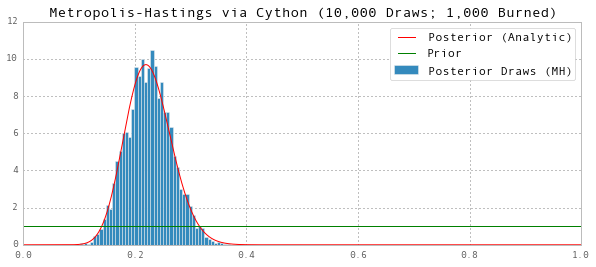

In [17]:
# Posterior Mean
print 'Posterior Mean (MH):', np.mean(thetas[G1:])

# Plot the posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
# Plot MH draws
ax.hist(thetas[G1:], bins=50, normed=True);
# Plot analytic posterior
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');
# Plot prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g')

# Cleanup
ax.set(title='Metropolis-Hastings via Cython (10,000 Draws; 1,000 Burned)', ylim=(0,12))
ax.legend(['Posterior (Analytic)', 'Prior', 'Posterior Draws (MH)']);

Now that we've improved the performance of our Metropolis-Hastings draws, we can increase the burn in period (although that is not necessary to ensure convergence in this case) and increase the number of draws from the converged posterior. Here we'll increase the burn in period and the post-convergence draws by a factor of 100 each. The total increase in runtime will almost exclusively be a result of the 100x increase in the post-convergence draws, so the runtime will likely increase by a factor of about 100).

Notice that this would be inconvenient using the pure Python or MATLAB code, since it would take about $100 \times 0.4 \text{s} \approx 40\text{s}$. Fortunately, our Cython implementation can run it in about $100 \times 0.02 \text{s} \approx 2\text{s}$.

In [18]:
G1 = 100000
G = 1000000

In [19]:
#%%timeit
print 'Timing: 1 loops, best of 3: 2.09 s per loop'
thetas = mh(0.5, nobs, Y.sum(), sigma, a1, a2, G1, G)

Timing: 1 loops, best of 3: 2.09 s per loop


Posterior Mean (MH): 0.225454350316


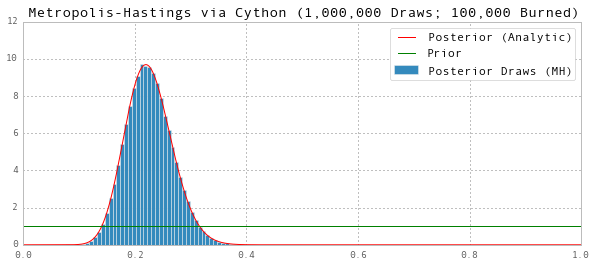

In [20]:
# Posterior Mean
print 'Posterior Mean (MH):', np.mean(thetas[G1:])

# Plot the posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
# Plot MH draws
ax.hist(thetas[G1:], bins=50, normed=True);
# Plot analytic posterior
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');
# Plot prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g')

# Cleanup
ax.set(title='Metropolis-Hastings via Cython (1,000,000 Draws; 100,000 Burned)', ylim=(0,12))
ax.legend(['Posterior (Analytic)', 'Prior', 'Posterior Draws (MH)']);

And with this many post-convergence draws, we can match the analytic posterior mean to 4 decimal places.

#### Metropolis-Hastings: PyMC

We can also make use of the [PyMC](https://github.com/pymc-devs/pymc) package to do Metropolis-Hastings runs for us. It is about twice as slow as the custom pure Python approach we employed above (and so ~40 times slower than the Cython implementation), but it is certainly much less work to set up!

(Note: I am not well-versed in PyMC, so it is certainly possible - likely, even - that there is a more performant way to do this).

In [21]:
G1 = 1000
G = 10000

In [22]:
#%%timeit
print 'Timing: 1 loops, best of 3: 590 ms per loop'

pymc_theta = pymc.Beta('pymc_theta', a1, a2, value=0.5)
pymc_Y = pymc.Bernoulli('pymc_Y', p=pymc_theta, value=Y, observed=True)

model = pymc.MCMC([pymc_theta, pymc_Y])
model.sample(iter=G+G1, burn=G1, progress_bar=False)

model.summary()
thetas = model.trace('pymc_theta')[:]

Timing: 1 loops, best of 3: 590 ms per loop

pymc_theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.224            0.042            0.001            [ 0.146  0.302]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.148            0.194           0.222          0.25          0.307
	


Posterior Mean (MH): 0.223732963864


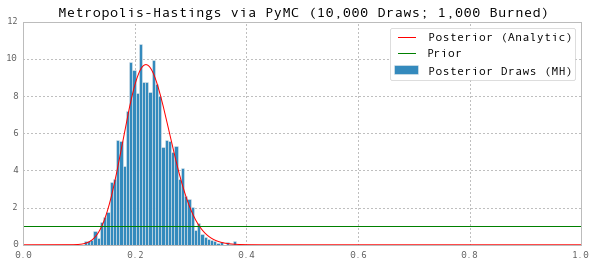

In [23]:
# Posterior Mean
# (use all of `thetas` b/c PyMC already removed the burn-in runs here)
print 'Posterior Mean (MH):', np.mean(thetas)

# Plot the posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
# Plot MH draws
ax.hist(thetas, bins=50, normed=True);
# Plot analytic posterior
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');
# Plot prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g')

# Cleanup
ax.set(title='Metropolis-Hastings via PyMC (10,000 Draws; 1,000 Burned)', ylim=(0,12))
ax.legend(['Posterior (Analytic)', 'Prior', 'Posterior Draws (MH)']);